In [1]:
%matplotlib inline
from modules.HandPose import HandPose
from modules.target import Target
import glob
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules.extract_video_duration import ExtractVideoDuration
from scipy import stats

In [2]:
path_map = {}
for folder in glob.glob("../data/VIDEO/*"):
    for file in glob.glob(folder + "/*.csv"):
        f = file.replace("\\", "/")
        key = f.split("/")[-1].split("_")[0]
        path_map[key] = f.split("_V")[0]

In [3]:
print(path_map)

{'2021-06-09-03-31-19-984': '../data/VIDEO/VIDEO_MANO_PROFESSORE/2021-06-09-03-31-19-984', '2021-06-09-03-41-56-213': '../data/VIDEO/VIDEO_MANO_PROFESSORE/2021-06-09-03-41-56-213', '2021-06-09-03-38-13-080': '../data/VIDEO/VIDEO_MANO_PROFESSORE/2021-06-09-03-38-13-080', '2021-06-09-03-35-34-328': '../data/VIDEO/VIDEO_MANO_PROFESSORE/2021-06-09-03-35-34-328', '2021-06-09-03-40-09-952': '../data/VIDEO/VIDEO_MANO_PROFESSORE/2021-06-09-03-40-09-952', '2021-06-09-03-33-38-376': '../data/VIDEO/VIDEO_MANO_PROFESSORE/2021-06-09-03-33-38-376', '2021-06-09-03-57-01-989': '../data/VIDEO/VIDEO_MANO_DAVIDE/2021-06-09-03-57-01-989', '2021-06-09-04-04-12-296': '../data/VIDEO/VIDEO_MANO_DAVIDE/2021-06-09-04-04-12-296', '2021-06-09-03-56-03-058': '../data/VIDEO/VIDEO_MANO_DAVIDE/2021-06-09-03-56-03-058', '2021-06-09-03-58-21-710': '../data/VIDEO/VIDEO_MANO_DAVIDE/2021-06-09-03-58-21-710', '2021-06-09-04-05-35-897': '../data/VIDEO/VIDEO_MANO_DAVIDE/2021-06-09-04-05-35-897', '2021-06-09-03-59-41-312': '.

In [4]:
train = [(path_map[file.replace("\\", "/").split("/")[-1].split("_")[0]]) for file in glob.glob("../data/train_set/*")]

In [5]:
test = [(path_map[file.replace("\\", "/").split("/")[-1].split("_")[0]]) for file in glob.glob("../data/test_set/*")]

In [6]:
val = [(path_map[file.replace("\\", "/").split("/")[-1].split("_")[0]]) for file in glob.glob("../data/val_set/*")]

In [7]:
def get_handpose_target_video(s):
    hand_pose = []
    target = []
    video_time = []
    for elem in s:
        h = HandPose(elem + "_handPose3D.txt")
        hand_pose.append(h.get_hand_pose_dict())
        target.append(Target.get(elem + "_action.json", 0))
        video_time.append(ExtractVideoDuration.get_duration(elem + "_Video.mp4"))
    return (hand_pose, target, video_time)

In [8]:
train_handpose, train_target, train_time = get_handpose_target_video(train)

In [9]:
test_handpose, test_target, test_time = get_handpose_target_video(test)

In [10]:
val_handpose, val_target, val_time = get_handpose_target_video(val)

In [11]:
def get_class_distribution(target_list, hand_dict_list):
    count_dict = {
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0
    }
    
    class2idx = {
        "Prendi": 0,
        "Rilascia": 1,
        "Premi": 2
    }
    for target, hand_dict in zip(target_list, hand_dict_list):
        for key in hand_dict:
            start_tim = int(key)
            i = -1
            for _, val in target.items():
                if val["time"][0] <= start_tim <= val["time"][1]:
                        i = class2idx[val["action"]]
            if i == 0: 
                count_dict['Prendi'] += 1
            elif i == 1: 
                count_dict['Rilascia'] += 1
            elif i == 2: 
                count_dict['Premi'] += 1            
    #         else:
    #             print("Check classes.")
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

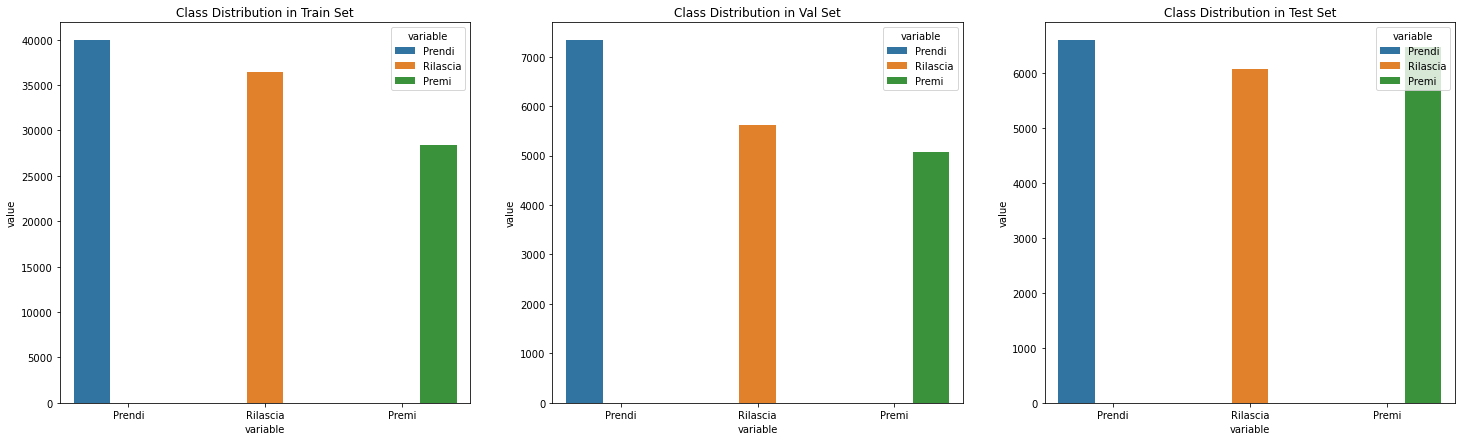

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_target, train_handpose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_target, val_handpose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_target, test_handpose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [13]:
hand_pose = train_handpose + val_handpose + test_handpose
target = train_target + val_target + test_target

Text(0.5, 1.0, 'Class Distribution')

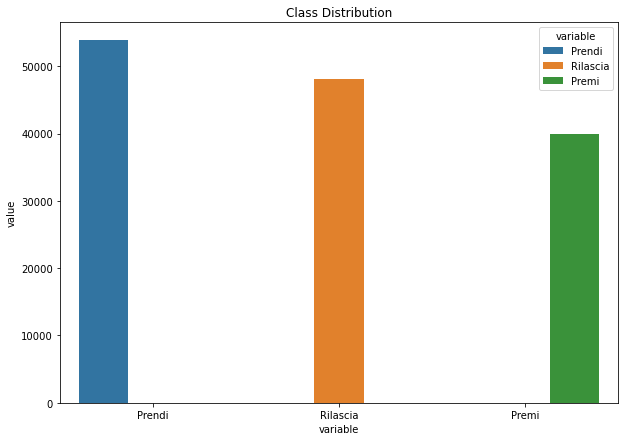

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(target, hand_pose)]).melt(), x = "variable", y="value", hue="variable",  ax=axes).set_title('Class Distribution')

In [15]:
df = pd.DataFrame.from_dict([get_class_distribution(target, hand_pose)])

In [16]:
df.describe()

,Prendi,Rilascia,Premi
count,1.0,1.0,1.0
mean,53844.0,48103.0,39928.0
std,NaN,NaN,NaN
min,53844.0,48103.0,39928.0
25%,53844.0,48103.0,39928.0
50%,53844.0,48103.0,39928.0
75%,53844.0,48103.0,39928.0
max,53844.0,48103.0,39928.0


In [17]:
video_time = train_time + test_time + val_time
train_t = np.array(train_time)
test_t = np.array(test_time)
val_t = np.array(val_time)
video_t = np.array(video_time)

In [18]:
print(stats.describe(video_t))

DescribeResult(nobs=56, minmax=(27100, 185330), mean=78156.375, variance=964370857.9477273, skewness=1.1284695521734494, kurtosis=1.7445334178892118)


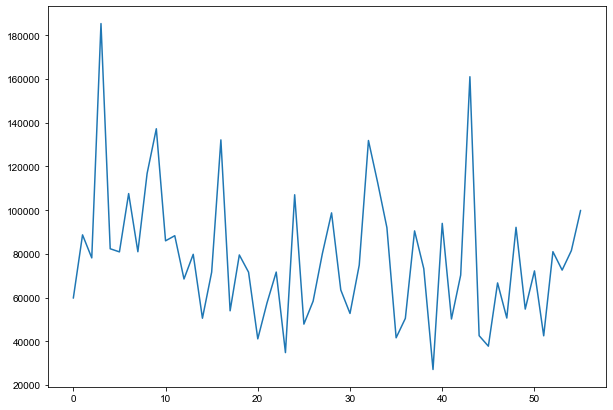

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.set_style("whitegrid")
plt.plot(video_t)
plt.show()

In [20]:
video_t.sum()

4376757

In [21]:
soggetti = 9

In [22]:
riprese_medie = len(video_t)/soggetti

In [23]:
video_person = []
for folders in glob.glob("../data/VIDEO/*"):
    video_person.append(len(glob.glob(folders + "\\*.mp4")))

In [24]:
video_person

[6, 6, 7, 9, 6, 6, 6, 5, 5]

,soggetto,value
0,0,6
1,1,6
2,2,7
3,3,9
4,4,6
5,5,6
6,6,6
7,7,5
8,8,5


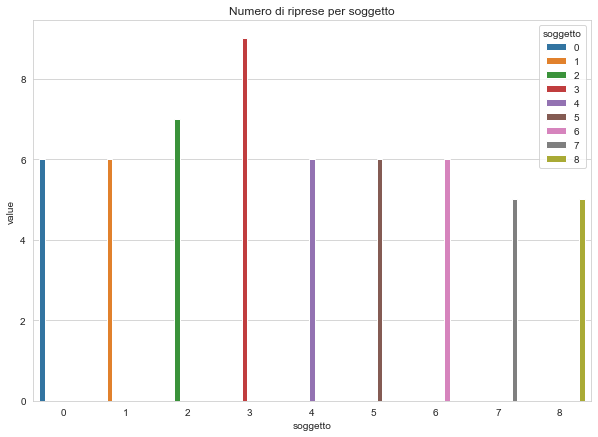

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.barplot(data = pd.DataFrame.from_dict(pd.DataFrame.from_dict([{key: val for val, key in zip(video_person, range(soggetti))}]).melt().rename(columns = {'variable': 'soggetto'}, inplace = False)), x = "soggetto", y="value", hue="soggetto",  ax=axes).set_title('Numero di riprese per soggetto')
plt.savefig('barplot.pdf') 

In [74]:
print(stats.describe(np.array(video_person)))

DescribeResult(nobs=9, minmax=(5, 9), mean=6.222222222222222, variance=1.4444444444444444, skewness=1.3897845345850157, kurtosis=1.3391272189349115)


In [54]:
video_place = []
for val in video_person:
    if val % 3 == 0:
        video_place.append([int(val/3), int(val/3), int(val/3)])
    elif val == 7:
        video_place.append([3, 2, 2])
    else:
        video_place.append([2, 2, 1])

In [55]:
video_place

[[2, 2, 2],
 [2, 2, 2],
 [3, 2, 2],
 [3, 3, 3],
 [2, 2, 2],
 [2, 2, 2],
 [2, 2, 2],
 [2, 2, 1],
 [2, 2, 1]]

In [65]:
place = {
    "Movimento": 0,
    "Seduto": 0,
    "Scaffale": 0
}
id2place = {
    0: "Movimento",
    1: "Seduto",
    2: "Scaffale"
}
for row, pos in zip(np.array(video_place).transpose(), range(3)):
    place[id2place[pos]] = row.sum()

In [66]:
place

{'Movimento': 20, 'Seduto': 19, 'Scaffale': 17}

Text(0.5, 1.0, 'Numero di video per luogo')

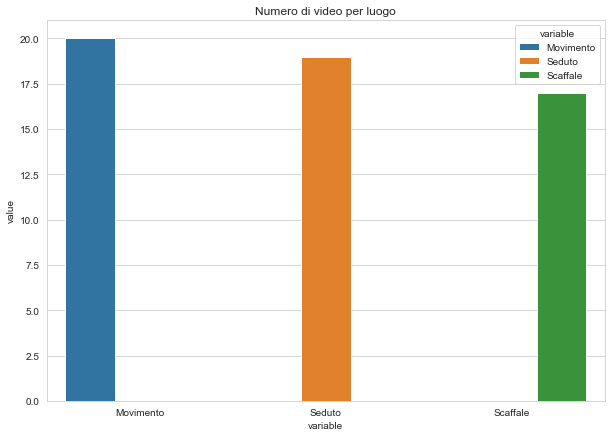

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.barplot(data = pd.DataFrame.from_dict([place]).melt(), x = "variable", y="value", hue="variable",  ax=axes).set_title('Numero di video per luogo')